In [23]:
import os
import pandas as pd
import zipfile
from io import StringIO
import matplotlib.pyplot as plt

In [11]:
def extract_and_process_data(root_folder):
    all_data = []
    
    # Traverse through the nested folder structure
    for year in os.listdir(root_folder):
        year_path = os.path.join(root_folder, year)
        if not os.path.isdir(year_path):
            continue
        
        for month in os.listdir(year_path):
            month_path = os.path.join(year_path, month)
            if not os.path.isdir(month_path):
                continue
            
            first_zip = True
            for file in os.listdir(month_path):
                if file.endswith(".zip"):
                    zip_path = os.path.join(month_path, file)
                    if first_zip:
                        print(f"Processing Year/Month: {month}")
                        first_zip = False
                    
                    with zipfile.ZipFile(zip_path, 'r') as z:
                        for filename in z.namelist():
                            with z.open(filename) as f:
                                df = pd.read_csv(f, delimiter=',', dtype={"PQ_description": str})  # Change "column_name" to actual column name
                                # Filter the required data
                                df_filtered = df[
                                    (df["PQ_unit"] == "cm") & 
                                    (df["PQ_name"] == "淹水深度") & 
                                    (df["value"] > 0)
                                ][["station_id", "timestamp", "value"]]
                                
                                all_data.append(df_filtered)
    
    # Combine all data into a single DataFrame
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

root_folder = './Data/raw_data'
records = extract_and_process_data(root_folder)

Processing Year/Month: 202207
Processing Year/Month: 202209
Processing Year/Month: 202208
Processing Year/Month: 202201
Processing Year/Month: 202206
Processing Year/Month: 202212
Processing Year/Month: 202203
Processing Year/Month: 202204
Processing Year/Month: 202205
Processing Year/Month: 202202
Processing Year/Month: 202211
Processing Year/Month: 202210
Processing Year/Month: 202311
Processing Year/Month: 202310
Processing Year/Month: 202304
Processing Year/Month: 202303
Processing Year/Month: 202302
Processing Year/Month: 202305
Processing Year/Month: 202312
Processing Year/Month: 202309
Processing Year/Month: 202307
Processing Year/Month: 202306
Processing Year/Month: 202301
Processing Year/Month: 202308
Processing Year/Month: 201907
Processing Year/Month: 201909
Processing Year/Month: 201908
Processing Year/Month: 201906
Processing Year/Month: 201901
Processing Year/Month: 201912
Processing Year/Month: 201904
Processing Year/Month: 201903
Processing Year/Month: 201902
Processing

/var/folders/t2/sk5q5lf54ds4j5jwz4wynx740000gn/T/ipykernel_56890/938937747.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(all_data, ignore_index=True)


In [21]:
# Check for duplicates in records
num_duplicates = records.duplicated().sum()
print(f"Number of duplicate rows in records: {num_duplicates}")

# Drop duplicates in records
records = records.drop_duplicates()

Number of duplicate rows in records: 737728


In [14]:
records

,station_id,timestamp,value
0,38505796-1525-4c8b-9d5c-27fea47db00f,2022-07-21 00:00:31.039,0.019717
1,38505796-1525-4c8b-9d5c-27fea47db00f,2022-07-21 00:09:31.974,0.020480
2,38505796-1525-4c8b-9d5c-27fea47db00f,2022-07-21 00:11:01.615,0.020215
3,38505796-1525-4c8b-9d5c-27fea47db00f,2022-07-21 00:19:31.676,0.019876
4,38505796-1525-4c8b-9d5c-27fea47db00f,2022-07-21 00:21:01.238,0.018207
...,...,...,...
10721802,38505796-1525-4c8b-9d5c-27fea47db00f,2020-12-30 18:20:00,0.000415
10721803,38505796-1525-4c8b-9d5c-27fea47db00f,2020-12-30 18:30:00,0.000111
10721804,38505796-1525-4c8b-9d5c-27fea47db00f,2020-12-30 19:30:00,0.000070
10721805,38505796-1525-4c8b-9d5c-27fea47db00f,2020-12-30 20:10:00,0.000259


In [15]:
# Read sensor files

sensors = pd.read_csv('./Data/sensors.csv')
sensors = sensors.drop(columns=['ciOrgname', 'OrgName', 'Code', 'PQ_id', 'FullName', 'Description', 'ciCategory', 'CategoryInfos_Name', 
                                'Address', 'PQ_name', 'station_name'])

# Only contain depth sensors
sensors.drop(sensors[sensors['SIUnit  '] != 'cm'].index, inplace=True)

# Remove abnormal values
sensors = sensors[~((sensors["Longitude"] == 120) & (sensors["Latitude"] == 23))]

In [16]:
# Check for duplicates in sensors
num_duplicates = sensors.duplicated().sum()
print(f"Number of duplicate rows in sensors: {num_duplicates}")

# Drop duplicates in sensors
sensors = sensors.drop_duplicates()

Number of duplicate rows in sensors: 19


In [17]:
sensors.head()

,station_id,Longitude,Latitude,SIUnit
0,648c0721-9ae3-4a3b-9007-31dd06a5f293,120.241250,23.450130,cm
1,b320d298-d3aa-4954-874a-79696f550efa,120.188995,23.428696,cm
2,c7c0c173-be6c-4fd2-b743-921d987e7330,120.392550,23.483112,cm
3,bc5af470-def9-4712-95da-8cc29c35fd60,120.160995,23.508854,cm
4,54c2b021-edc6-418f-bff5-ec96067b24e6,120.433920,23.441912,cm


In [20]:
# Join dataframes on station_id
df = records.merge(sensors, on='station_id', how='inner')

In [21]:
# Drop NAs on final df
print("Number of missing values per column before dropping:")
print(df.isna().sum())  # Counts NaN values for each column

df = df.dropna(subset=['Longitude', 'Latitude'])

Number of missing values per column before dropping:
station_id    0
timestamp     0
value         0
Longitude     0
Latitude      0
SIUnit        0
dtype: int64


In [49]:
df

,station_id,timestamp,value,Longitude,Latitude,SIUnit
0,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:08:57.2,0.001000,120.69100,23.903200,cm
1,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:18:57.382,0.001000,120.69100,23.903200,cm
2,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:28:58.358,0.001000,120.69100,23.903200,cm
3,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:38:58.793,0.001000,120.69100,23.903200,cm
4,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:48:59.713,0.001000,120.69100,23.903200,cm
...,...,...,...,...,...,...
7033453,5abec613-f581-4bf9-b41c-dc0619c950c4,2020-12-11 11:30:00,1.545227,120.30970,23.654995,cm
7033454,5abec613-f581-4bf9-b41c-dc0619c950c4,2020-12-11 15:03:18.016,1.504207,120.30970,23.654995,cm
7033455,a2015019-1ecc-48a2-938d-393a289e7a9a,2020-12-11 10:05:17.262,1.022019,120.35272,23.652205,cm
7033456,ae9eb0c9-a435-4b9a-b5e2-08d00c43b231,2020-12-11 07:30:00,1.500928,120.47167,23.642970,cm


In [22]:
# Number of unique stations
df['station_id'].value_counts()

station_id
a3550f5f-34eb-4364-bd5d-c51a115ea6b7    292476
1c8f0f5d-7940-4734-b59a-4f0031ef5304    275132
e375e985-80ae-4b6e-a30f-8c061351f2a7    261480
e040cbc5-e893-4a32-b3e1-e5b3232b00e6    258854
969cc500-c74c-4aea-9f2a-687fa2135d92    251559
                                         ...  
2784418c-ce89-4cb2-9642-a20078b156ef         1
852ab211-20ce-4d29-ab00-ddda2333438e         1
bfa6bea8-1389-4a50-80c3-36518c53bc67         1
c0a2badb-dfe3-4ae4-b449-e070ee7346dd         1
3ce0ec63-477c-4b5a-bbcb-a0324db67ef8         1
Name: count, Length: 1383, dtype: int64

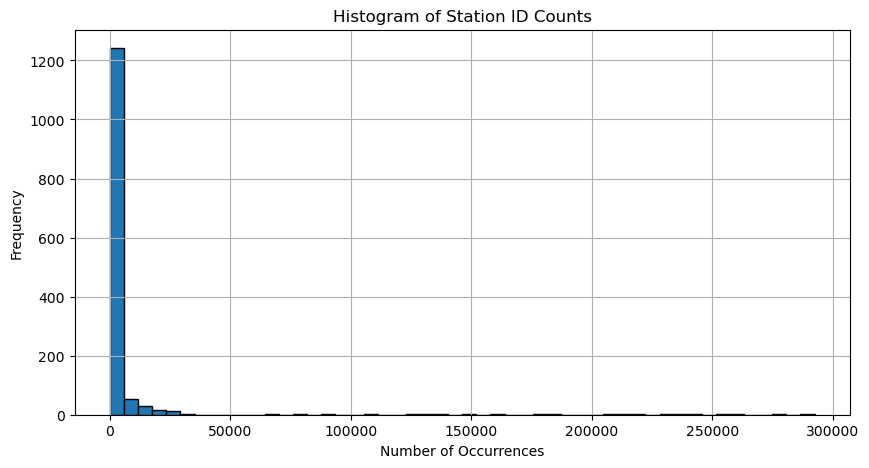

In [24]:
# Plot histogram of number of unique stations

# Plot histogram
plt.figure(figsize=(10, 5))
df['station_id'].value_counts().hist(bins=50, edgecolor='black')

# Labels and title
plt.xlabel("Number of Occurrences")
plt.ylabel("Frequency")
plt.title("Histogram of Station ID Counts")

# Show plot
plt.show()

In [40]:
# Distribution of flood depth
df['value'].describe()

count    7.033458e+06
mean     7.824419e+02
std      1.041063e+03
min      1.000000e-04
25%      5.000000e-01
50%      6.600000e+00
75%      1.910000e+03
max      6.038774e+05
Name: value, dtype: float64

In [41]:
df.head()

,station_id,timestamp,value,Longitude,Latitude,SIUnit
0,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:08:57.2,0.001,120.691,23.9032,cm
1,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:18:57.382,0.001,120.691,23.9032,cm
2,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:28:58.358,0.001,120.691,23.9032,cm
3,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:38:58.793,0.001,120.691,23.9032,cm
4,d83ac636-3d28-43fe-96a9-5c33dde8aebe,2022-07-21 00:48:59.713,0.001,120.691,23.9032,cm


In [32]:
# Export to csv
df.to_csv("df.csv", index=False)